In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled.

2.0.1
True


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch import nn
from torch import optim
import torch.nn.functional as F
import time
from PIL import Image
import os, glob
import numpy as np

## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, I applied transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I also resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this I did not apply any scaling or rotation transformations, but I resized then cropped the images to the appropriate size.

The pre-trained networks I used were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I normalized the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [52]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [53]:
#Define transforms for the training, validation, and testing sets
data_transforms = {'train': transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomResizedCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485,0.456,0.406],
                                                          [0.229, 0.224, 0.225])]),
                   'val': transforms.Compose([transforms.Resize(224),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485,0.456,0.406],
                                                                [0.229, 0.224, 0.225])]),
                   'test': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485,0.456,0.406],
                                                          [0.229, 0.224, 0.225])])}

#Load datasets with ImageFolder
image_datasets = {'train': datasets.ImageFolder(train_dir, transform = data_transforms['train']),
                  'val': datasets.ImageFolder(valid_dir, transform = data_transforms['val']),
                  'test': datasets.ImageFolder(test_dir, transform = data_transforms['test'])}

#Using the image datasets and the trainforms, define the dataloaders
dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size = 5, shuffle=True),
               'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size = 5, shuffle=True),
               'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size = 5, shuffle=True)}

print(len(dataloaders['train']))
print(len(dataloaders['val']))
print(len(dataloaders['test']))

1311
164
164


### Label mapping

Load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`.This gives a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

I used one of the pretrained models from `torchvision.models` to get the image features. I built and trained a new feed-forward classifier using those features.

I did the following:

* Loaded a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) 
* Defined a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Trained the classifier layers using backpropagation using the pre-trained network to get the features
* Tracked the loss and accuracy on the validation set to determine the best hyperparameters

When training, I made sure you're updating only the weights of the feed-forward network. I tried different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. I saved those hyperparameters to use as default values in the command-line interface. I also saved the checkpoint so I can load it later and resume training if I wanted to. I also made sure to include the option to use the GPU to train if it's available.

In [6]:
#device agnostic
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [167]:
#pretrained network
model = models.densenet169(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [8]:
#freeze parameters
for param in model.parameters():
    param.requires_grad = False

In [188]:
#feed-forward network
model.classifier = nn.Sequential(nn.Linear(1664, 1024),
                                 nn.ReLU(),
                                 nn.Linear(1024,512),
                                 nn.ReLU(),
                                 nn.Linear(512,256),
                                 nn.ReLU(),
                                 nn.Linear(256,128),
                                 nn.ReLU(),
                                 nn.Dropout(),
                                 nn.Linear(128,102),
                                 nn.LogSoftmax(dim=1))

#loss
criterion = nn.NLLLoss()

#optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [10]:
epochs = 30
steps = 0

train_losses, validation_losses, accuracy_score = [], [], []
for e in range(epochs):
    start = time.time()
    total_train_loss = 0
    for inputs, labels in dataloaders['train']:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)


        logs = model.forward(inputs)
#         logs.requires_grad=True
        loss = criterion(logs, labels)
        total_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    else:
        total_validation_loss = 0
        accuracy = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)

                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)

                total_validation_loss += batch_loss.item()

                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

            train_loss = total_train_loss/len(dataloaders['train'])
            validation_loss = total_validation_loss/len(dataloaders['val'])

            train_losses.append(train_loss)
            validation_losses.append(validation_loss)
            accuracy_score.append(accuracy.item())

        print('Epoch {}/{}...'.format(e+1,epochs),
              'Train Loss: {:.3f}... '.format(train_loss),
              'Validation Loss: {:.3f}... '.format(validation_loss),
              'Validation Accuracy: {:.2f}%... '.format(accuracy.item()))
        print(f'Time: {int((time.time() - start)/60)}min, {(time.time() - start) % 60:.3f}s')
        train_loss = 0
        model.train()



Epoch 1/30... Train Loss: 4.428...  Validation Loss: 4.063...  Validation Accuracy: 11.80%...  Time: 45.858
Epoch 2/30... Train Loss: 4.172...  Validation Loss: 3.847...  Validation Accuracy: 12.40%...  Time: 1.952
Epoch 3/30... Train Loss: 3.976...  Validation Loss: 3.547...  Validation Accuracy: 16.53%...  Time: 1.887
Epoch 4/30... Train Loss: 3.771...  Validation Loss: 3.272...  Validation Accuracy: 25.13%...  Time: 1.852
Epoch 5/30... Train Loss: 3.557...  Validation Loss: 2.964...  Validation Accuracy: 38.40%...  Time: 1.827
Epoch 6/30... Train Loss: 3.385...  Validation Loss: 2.743...  Validation Accuracy: 40.13%...  Time: 1.813
Epoch 7/30... Train Loss: 3.221...  Validation Loss: 2.738...  Validation Accuracy: 43.00%...  Time: 1.834
Epoch 8/30... Train Loss: 3.164...  Validation Loss: 2.604...  Validation Accuracy: 42.80%...  Time: 1.834
Epoch 9/30... Train Loss: 3.033...  Validation Loss: 2.298...  Validation Accuracy: 54.13%...  Time: 1.823
Epoch 10/30... Train Loss: 2.998... 

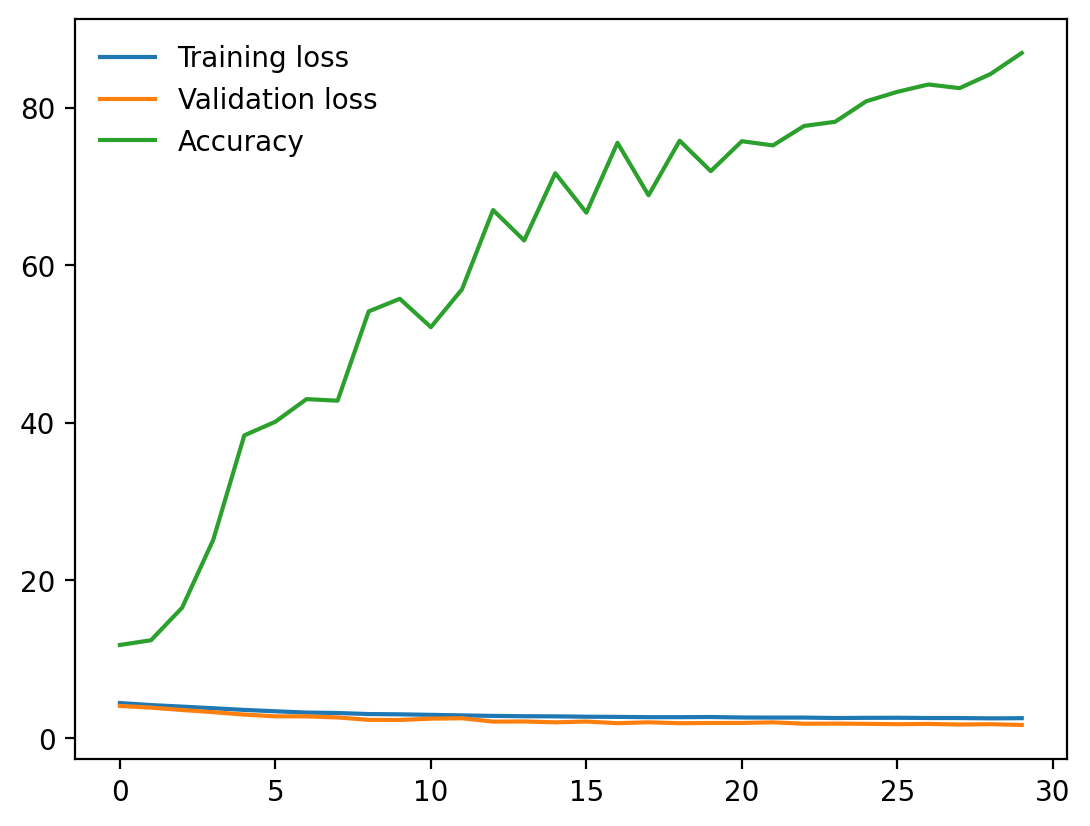

In [11]:
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.plot(accuracy_score, label='Accuracy')
plt.legend(frameon=False)

## Testing the network

In [16]:
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)

        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)

        test_loss += batch_loss.item()

        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))


print(f'Test Accuracy: {accuracy.item()}... ')
model.train()

Test Accuracy: 79.54999542236328... 


## Save the checkpoint

I save the model so I could load it later for making predictions. I also saved the mapping of classes to indices which I got from one of the image datasets: `image_datasets['train'].class_to_idx`. I attached this to the model as an attribute which made inference easier later on.

In [ ]:
#Save the checkpoint
model.class_to_idx = image_datasets['train'].class_to_idx
checkpoint = {'class_to_idx': model.class_to_idx,
              'epochs': epochs,
              'steps': steps,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'criterion_state_dict': criterion.state_dict(),
              }
torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

I wrote a function that loaded the checkpoint and rebuilt the model.

In [7]:
#function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    loaded_model = models.densenet169(pretrained=False)
    loaded_model.classifier = nn.Sequential(nn.Linear(1664, 1024),
                                          nn.ReLU(),
                                          nn.Linear(1024,512),
                                          nn.ReLU(),
                                          nn.Linear(512,256),
                                          nn.ReLU(),
                                          nn.Linear(256,128),
                                          nn.ReLU(),
                                          nn.Dropout(),
                                          nn.Linear(128,102),
                                          nn.LogSoftmax(dim=1))

    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.to(device)
    return checkpoint, loaded_model

# Inference for classification

I wrote a function to use the trained network for inference. I wrote a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities.


## Image Preprocessing

I used `PIL` to load the image ([PIL](https://pillow.readthedocs.io/en/latest/reference/Image.html)). I wrote a function that preprocesses the image so it can be used as input for the model. This function processed the images in the same manner used for training.

First, I resized the images where the shortest side wass 256 pixels, keeping the aspect ratio. Then I cropped out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. I converted the values with a Numpy array, which I got from the PIL image.

I also normalized the images by subtracting the means from each color channel, then dividing by the standard deviation.
Then I reordered the dimensions so that color channel comes first using `ndarray.transpose`.

In [9]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    image = Image.open(image)
    
    image.thumbnail((224,224))
    width, height = image.size
    left = (width - 224)/2
    right = (width + 224)/2
    top = (height - 224)/2
    bottom = (height + 224)/2
    image.crop((left, top, right, bottom))

    np_image = np.array(image)
    np_image = np_image/255.0

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.485, 0.456, 0.406])
    np_image = (np_image - mean)/std

    np_image.transpose((2,0,1))

    return np_image

The function below converted the PyTorch tensor and displayed it in the notebook. This was to make sure the `process_image` function worked properly.

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 0, 2))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

<Axes: >

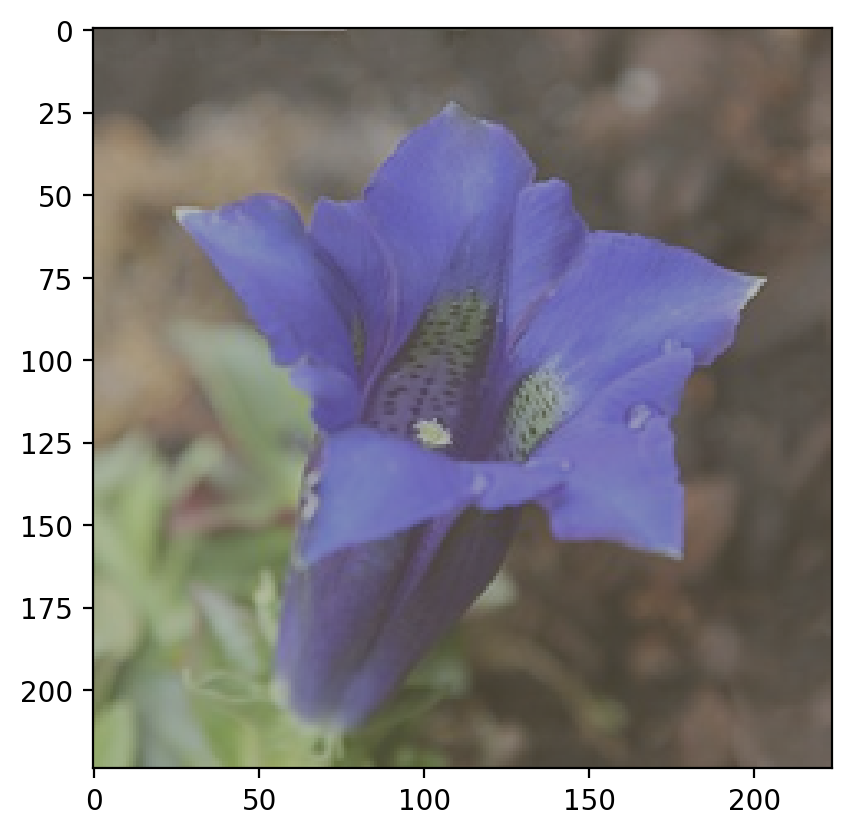

In [ ]:
image = process_image('image.jpg')
imshow(image)

## Class Prediction

I wrote a function for making predictions with my model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. So I calculated the class probabilities then found the $K$ largest values.

To get the top $K$ largest values in a tensor, I used [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. I converted from these indices to the actual class labels using `class_to_idx` which I added to the model. I made sure to invert the dictionary so I got a mapping from index to class as well.

In [ ]:
def predict(image_path, checkpoint_path, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    checkpoint, model = load_checkpoint(checkpoint_path)
    model.to(device)
    model.eval()

    processed_image = process_image(image_path)
    image_tensor = torch.tensor(processed_image, dtype=torch.float32)
    image_tensor = image_tensor.to(device)
    image_tensor = image_tensor.permute(2,0,1)
    image_tensor = image_tensor.unsqueeze(0)

    with torch.no_grad():
        output = model(image_tensor)

    ps = torch.exp(output)
    top_p, top_class_indices = ps.topk(topk)
    mapping = checkpoint['class_to_idx']
    idx_to_class = {v: k for k,v in mapping.items()}
    top_classes = [idx_to_class[idx.item()] for idx in top_class_indices[0]]

    top_p = top_p[0].cpu().numpy()
    top_class = np.array(top_classes)

    return top_p, list(top_class)

## Sanity Checking

Now that I could use my trained model for predictions, I checked to make sure it made sense. I used `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. 

I converted from the class integer encoding to actual flower names with the `cat_to_name.json` file. I used the `imshow` function defined above yo show the PyTorch tensor as an image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.74364525 0.20991646 0.03342044 0.00371563 0.00257007] ['51', '98', '76', '55', '1']
['petunia', 'mexican petunia', 'morning glory', 'pelargonium', 'pink primrose']


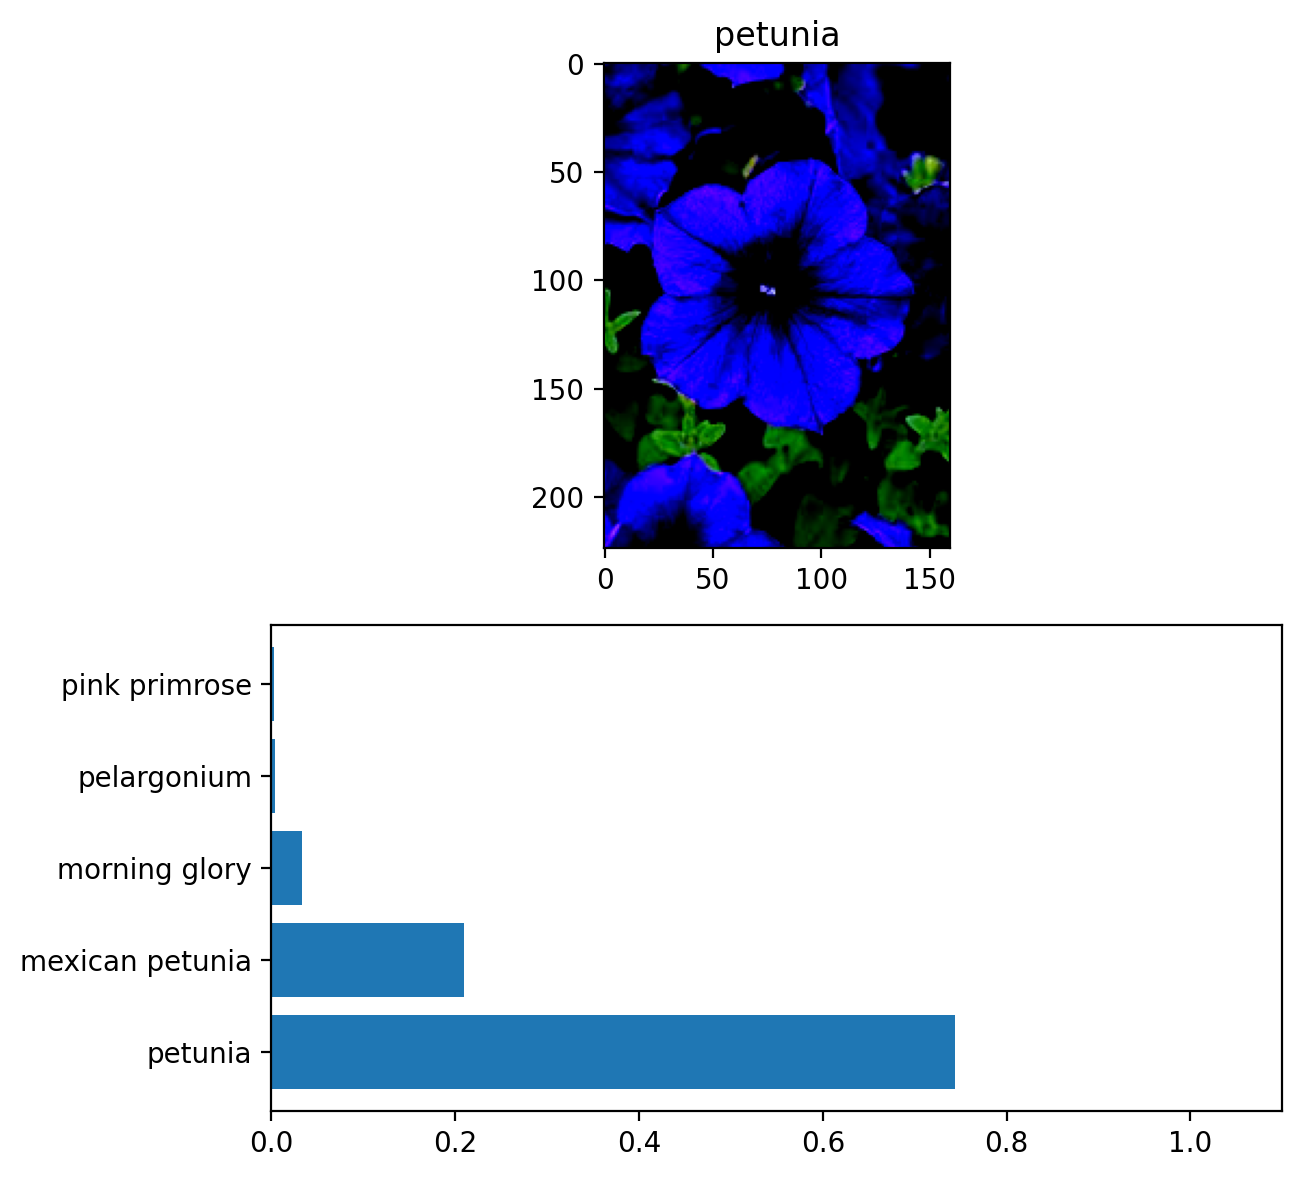

In [ ]:
#Display an image along with the top 5 classes
top_p, top_class = predict('image2.jpg','checkpoint.pth')
print(top_p,top_class)

def map_num(indices):
    return cat_to_name[indices]
names = list(map(map_num,top_class))
print(names)

fig, (ax1,ax2) = plt.subplots(figsize = (9,6), nrows = 2) 
ax1.imshow(process_image('image2.jpg'))
ax1.set_title(names[0])
ax2.barh(np.arange(5), top_p)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(5))
ax2.set_yticklabels(names)
ax2.set_xlim(0, 1.1)
plt.tight_layout()